#### IMPORTING THE LIBRARIES

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
import datetime as dt

#### PREPROCESSING

In [36]:
dataset = pd.read_csv('stock_data.csv',parse_dates = ['Date'])
dataset.head()

,Unnamed: 0,Name,Date,Open,Closing_Price,Daily_High,Daily_Low,Volume
0,0,Accor,2020-04-03,22.99,23.40,23.40,22.99,67
1,1,Accor,2020-04-02,23.91,22.99,23.91,22.99,250
2,2,Accor,2020-04-01,24.10,23.83,24.10,23.83,37
3,3,Accor,2020-03-31,25.04,25.00,25.24,24.99,336
4,4,Accor,2020-03-30,26.50,25.02,26.50,24.99,415


In [37]:
def load_data(company,start,end):
    dataframe = dataset.copy()
    dataframe = dataframe.loc[(dataframe['Date'] > start) & (dataframe['Date'] < end), :]
    dataframe = dataframe.loc[dataframe.Name == company, :]
    dataframe = dataframe.rename(columns = {'Closing_Price': 'Close'})
    return dataframe

In [38]:
company = 'Accor'
start_date = dt.datetime(2015,1,1)
end_date = dt.datetime(2020,1,1)
start_date_test = end_date

In [39]:
data = load_data(company = company,start = start_date, end = end_date)
data.head()

,Unnamed: 0,Name,Date,Open,Close,Daily_High,Daily_Low,Volume
67,67,Accor,2019-12-30,42.10,42.10,42.10,42.10,NaN
68,68,Accor,2019-12-27,41.92,42.20,42.20,41.92,135
69,69,Accor,2019-12-23,41.08,42.09,42.09,41.08,10
70,70,Accor,2019-12-20,41.26,41.26,41.26,41.26,NaN
71,71,Accor,2019-12-19,41.31,41.31,41.31,41.31,NaN


#### NORMALIZE THE DATA

In [40]:
scaler = MinMaxScaler(feature_range = (0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))
#reshape(-1,1) reshapes the data into a 1D array with one columns and the required number of rows.
print(scaled_data.shape)

(1262, 1)


#### Splitting into x_train and y_train and transforming 2D array to 3D array.

In [41]:
#So we what we are doing here is basically creating dependent and independent features for the dataset.
#We are using a time step of 60
#This means that every 61st day of prediction is based on the previous 60 days.
#For x_train first row consists of values FROM 0 TO 59.
#For y_train first row consists of the 60th value.
#For x_train second row consists of values from 1 to 60 values.
#For y_train second row consists of 61st value.
prediction_days = 60
x_train = []
y_train = []
for x in range(prediction_days,len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x,0])
    y_train.append(scaled_data[x,0])
x_train, y_train = np.array(x_train), np.array(y_train)
#Here x_train.shape is a tuple with the dimensions 2539 * 60
#x_train.shape[0] refers to 2539
#x_train[0].shape refers to the shape of the first array of x_train  which is 60 rows.
print(x_train.shape)
#HERE WE ARE CONVERTING A 2D ARRAY TO A 3D ARRAY
#The 3 parameters of np.reshape are (layers,rows,colums)
#So the final 3D array has 2539 layers, 60 rows and 1 column.
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))
print(x_train.shape)

(1202, 60)
(1202, 60, 1)


#### BUILDING THE LSTM MODEL

We can create a Keras model using Sequential.  
The Sequential model is a linear stack of layers.  
A Sequential model can be created by passing a list of layer instances to the Sequential constructor or you can simply add layers via the .add() method.

return sequences =  true returns the output of all the hidden state of each time step.  
The output is a 3D array of real numbers.  
The first dimension is indicating the number of samples in the batch given to the LSTM layer.  
The second dimension is the number of time steps in the input sequence.  
The third dimension is the dimensionality of the output space defined by the units parameter in Keras LSTM implementation.  
Units is the number of neurons in each layer.  
Dropout is a technique where randomly selected neurons are ignored during training.  
They are "dropped out" randomly.  
Due to this other neurons have to step in and handle the representation required to make predictions for the missing neurons.  
So, the network becomes less sensitive to the specific weights of the neurons.  
Here the dropout rate is 20%, which means that one in five inputs will be randomly excluded from each update cycle.  
Thus, this prevents OVERFITTING of the neural network.  
Dense is basically a densely connected neural network layer and units if the number of neurons in the layers.  

In [42]:
def LSTM_model():
    model = Sequential()
    model.add(LSTM(units = 50, return_sequences=True, input_shape = (x_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units = 50,return_sequences=True,input_shape=(x_train.shape[1],1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.1))
    model.add(Dense(units = 1))
    return model

#### TRAINING

In [43]:
model = LSTM_model()
model.summary()
model.compile(optimizer='adam',loss='mean_squared_error')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 60, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [44]:
checkpointer = ModelCheckpoint(filepath = 'weights_best.hdf5',verbose=2,save_best_only=True)
model.fit(x_train, y_train, epochs=25,batch_size=32, callbacks=[checkpointer])

Epoch 1/25
38/38 [==============================] - 6s 59ms/step - loss: 0.0602
Epoch 2/25
38/38 [==============================] - 2s 62ms/step - loss: 0.0097
Epoch 3/25
38/38 [==============================] - 2s 65ms/step - loss: 0.0083
Epoch 4/25
38/38 [==============================] - 3s 68ms/step - loss: 0.0084
Epoch 5/25
38/38 [==============================] - 2s 62ms/step - loss: 0.0074
Epoch 6/25
38/38 [==============================] - 2s 61ms/step - loss: 0.0067
Epoch 7/25
38/38 [==============================] - 2s 65ms/step - loss: 0.0064
Epoch 8/25
38/38 [==============================] - 2s 62ms/step - loss: 0.0065
Epoch 9/25
38/38 [==============================] - 2s 64ms/step - loss: 0.0064
Epoch 10/25
38/38 [==============================] - 3s 66ms/step - loss: 0.0059
Epoch 11/25
38/38 [==============================] - 2s 64ms/step - loss: 0.0063
Epoch 12/25
38/38 [==============================] - 3s 74ms/step - loss: 0.0055
Epoch 13/25
38/38 [==================

#### PREDICTIONS

In [45]:
test_data = load_data(company = company, start = start_date_test,end = dt.datetime.now())
actual_prices = test_data['Close'].values
total_dataset = pd.concat((data['Close'], test_data['Close']), axis = 0)
model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

C:\Users\Shreya\AppData\Local\Temp\ipykernel_11840\3267007943.py:4: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values


In [46]:
x_test = []
for x in range(prediction_days,len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])
x_test = np.array(x_test)
#converting to 3D array.
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

3/3 [==============================] - 1s 18ms/step


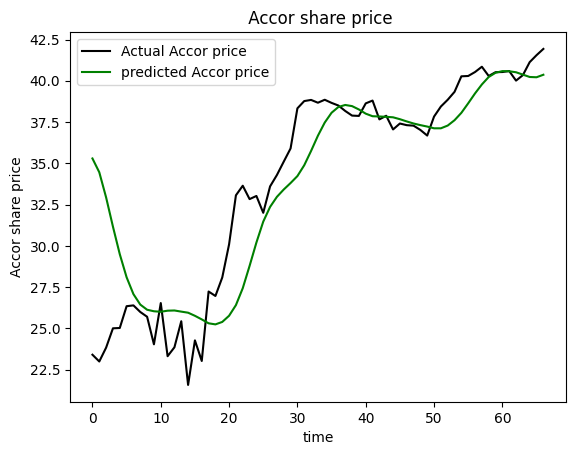

In [47]:
plt.plot(actual_prices, color = 'black',label=f"Actual {company} price")
plt.plot(predicted_prices, color='green',label=f"predicted {company} price")
plt.title(f" {company} share price")
plt.xlabel("time")
plt.ylabel(f"{company} share price")
plt.legend()
plt.show()

#### Predicting the next day

In [48]:
real_data = [model_inputs[len(model_inputs)+1 - prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1],1))

In [49]:
prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"prediction: {prediction}")

1/1 [==============================] - 1s 698ms/step
prediction: [[40.668236]]
